# Modeling: Association Rules for Frequent Patterns 

This notebook focuses on Association Rules, a key technique in data mining that will heps us find patterns and relationships within datasets. Our goal is to use the Apriori algorithm, in order to analyze visitation data from a collection of tourist attractions to identify frequently co-visited sites and derive actionable insights.

We will be finding patterns on Portugal´s attractions based on the ID´s provided in our dataset:
- `MAG010`: Torre de Belém, Lisbon
- `MAG014`: Mosteiro dos Jerónimos, Lisbon
- `MAG021`: Ponte de D. Luís I, Porto
- `MAG032`: Parque Nacional e Palácio da Pena, Sintra
- `MAG047`: Quinta da Regaleira, Sintra
- `MAG049`: Cais da Ribeira, Porto
- `MAG093`: Bom Jesus do Monte, Braga

The goal of this analysis is to explore:
- Which attractions are commonly visited together.
- How we can leverage these patterns to improve tourism offerings, such as creating bundled passes, optimizing itineraries, or enhancing marketing strategies.

The dataset that was utilized is `cleaned_data.csv`

## Initial setup and modules/packages loading

In [22]:
# Packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import joypy
import re
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import networkx as nx
from mlxtend.preprocessing import TransactionEncoder

In [23]:
subPlots_Title_fontSize = 12
subPlots_xAxis_fontSize = 10
subPlots_yAxis_fontSize = 10
subPlots_label_fontSize = 10
heatmaps_text_fontSize = 8

plots_Title_fontSize = 14
plots_Title_textColour = 'black'

plots_Legend_fontSize = 12
plots_Legend_textColour = 'black'

## Data Understanding

The Data Understanding section begins by loading the dataset `cleaned_data.csv` and applying a filter to focus exclusively on specific tourist attractions identified by their unique `localID`.
Since we are going to be focusing our analysis on Portugal´s attractions. 

In [24]:
# Load data 
df = pd.read_csv("cleaned_data.csv", delimiter=";")
local_ids = ["MAG010", "MAG014", "MAG021", "MAG032", "MAG047", "MAG049", "MAG093"]
ds = df[df['localID'].isin(local_ids) ]
#ds['userName'] = df['userName'].apply(lambda x: x.split('@')[-1])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33879 entries, 0 to 33878
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   localID            33879 non-null  object 
 1   extractionDate     33879 non-null  object 
 2   globalRating       33879 non-null  float64
 3   positionOnRanking  33879 non-null  int64  
 4   sitesOnRanking     33879 non-null  int64  
 5   totalReviews       33879 non-null  int64  
 6   userName           33879 non-null  object 
 7   userLocation       33879 non-null  object 
 8   userContributions  33879 non-null  int64  
 9   tripType           33879 non-null  object 
 10  reviewWritten      33879 non-null  object 
 11  reviewVisited      33879 non-null  object 
 12  reviewRating       33879 non-null  int64  
 13  reviewLanguage     33879 non-null  object 
 14  reviewFullText     33879 non-null  object 
dtypes: float64(1), int64(5), object(9)
memory usage: 3.9+ MB


C:\Users\laura\AppData\Local\Temp\ipykernel_23584\1889175741.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds['localName'] = ds['localID'].map(local_id_to_name)


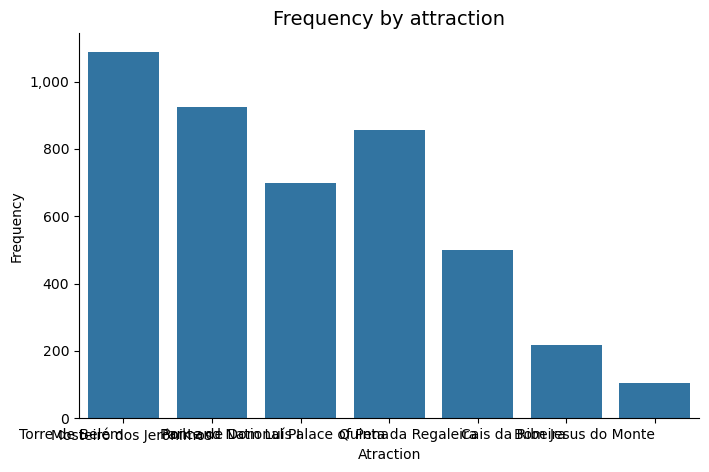

In [25]:
# Frequency by attractions

# Map localID to localName
local_id_to_name = {
    "MAG010": "Torre de Belém",
    "MAG014": "Mosteiro dos Jerónimos",
    "MAG021": "Ponte de Dom Luís I",
    "MAG032": "Park and National Palace of Pena",
    "MAG047": "Quinta da Regaleira",
    "MAG049": "Cais da Ribeira",
    "MAG093": "Bom Jesus do Monte"
}
ds['localName'] = ds['localID'].map(local_id_to_name)

# Frequency by attractions
fig, ax = plt.subplots(figsize=(8, 5))
g = sns.countplot(data=ds, x='localName')  

# Decoration
fmt = "{x:,.0f}"
tick = ticker.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
sns.despine()
plt.title("Frequency by attraction", fontsize=plots_Title_fontSize)
plt.xlabel("Atraction")
plt.ylabel("Frequency")
plt.rc('axes', labelsize=subPlots_label_fontSize)
plt.xticks(rotation=0, ha='right');

This part of the code changes the attraction IDs (`localID`) into their actual names (`localName`) using a dictionary, so it’s easier to understand. After that, it creates a bar chart to show how often each attraction was visited, with the x-axis listing the attractions and the y-axis showing the number of visits. To make the chart look better, the y-axis labels are formatted nicely, and some extra lines on the plot are removed. The chart also has a title and labeled axes, making it easy to see which attractions are the most or least visited. This helps us get a quick idea of the popularity of each place before diving into deeper analysis.

We could also tell from this that Torre de Belém is the most visited attraction, with over 1,200 visits. Followed by Palácio da Pena. Bom Jesus has the lowest frequency of visits, suggesting it might be less popular or less accessible compared to the other attractions. This makes sense since it is located in Braga and usually there are less turist visiting other regions of Portugal other than Porto or Lisboa. However it is a good insight because Porto is closer in location to Braga, so that could potentially lead to a marketing strategy idea. 


Bellow was our attempt to make the chart more readable.

C:\Users\laura\AppData\Local\Temp\ipykernel_23584\2371112560.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds['localName'] = ds['localID'].map(local_id_to_name)


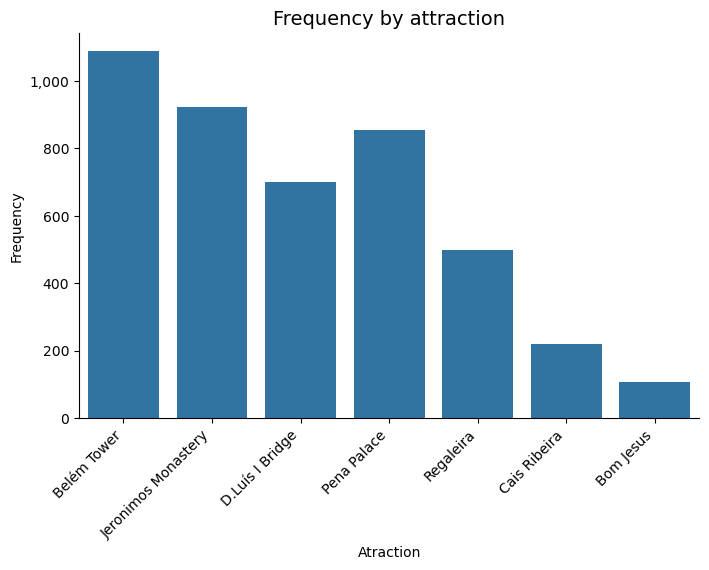

In [26]:
# Frequency by attractions

# Map localID to localName
local_id_to_name = {
    "MAG010": "Belém Tower",
    "MAG014": "Jeronimos Monastery",
    "MAG021": "D.Luís I Bridge",
    "MAG032": "Pena Palace",
    "MAG047": "Regaleira",
    "MAG049": "Cais Ribeira",
    "MAG093": "Bom Jesus"
}
ds['localName'] = ds['localID'].map(local_id_to_name)

# Frequency by attractions
fig, ax = plt.subplots(figsize=(8, 5))
g = sns.countplot(data=ds, x='localName')  

# Decoration
fmt = "{x:,.0f}"
tick = ticker.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
sns.despine()
plt.title("Frequency by attraction", fontsize=plots_Title_fontSize)
plt.xlabel("Atraction")
plt.ylabel("Frequency")
plt.rc('axes', labelsize=subPlots_label_fontSize)
plt.xticks(rotation=45, ha='right');

C:\Users\laura\AppData\Local\Temp\ipykernel_23584\1607590983.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds['reviewVisited'] = pd.to_datetime(ds['reviewVisited'], errors='coerce')
C:\Users\laura\AppData\Local\Temp\ipykernel_23584\1607590983.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds['Month'] = ds['reviewVisited'].dt.month


<Figure size 800x500 with 0 Axes>

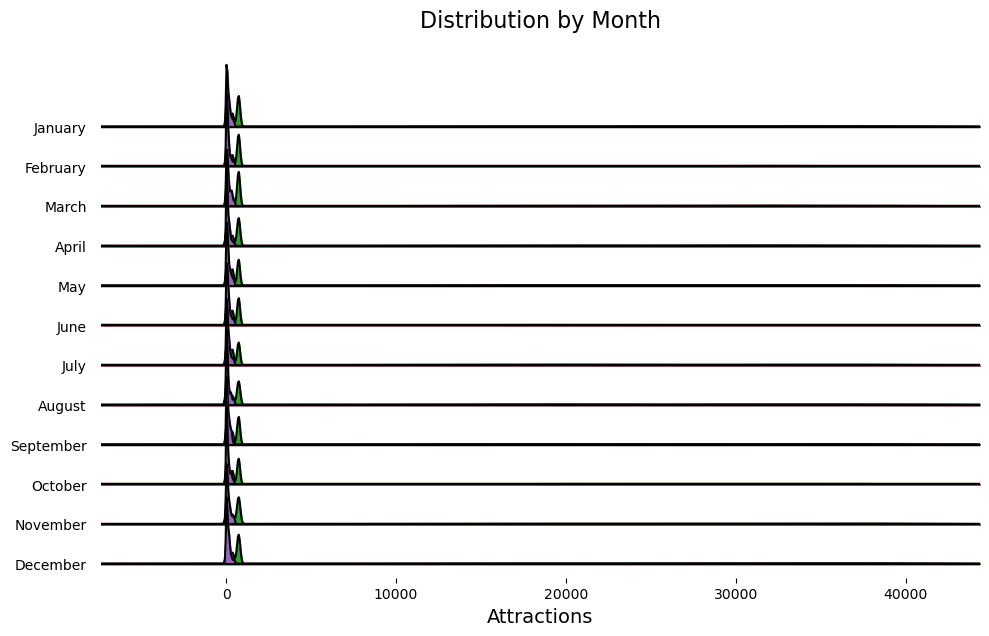

In [27]:
# Ensure 'reviewVisited' is in datetime format
ds['reviewVisited'] = pd.to_datetime(ds['reviewVisited'], errors='coerce')

# Create a column with the day of the month (numeric: January=0, December=11)
ds['Month'] = ds['reviewVisited'].dt.month

# Define the weekdays list for mapping the numeric days
monthsList = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Plotting
plt.figure(figsize=(8, 5))
joypy.joyplot(
    data=ds,
    by='Month',
    labels=monthsList,
    figsize=(10, 6)
)

# Decoration
plt.title("Distribution by Month", fontsize=16)
plt.xlabel("Attractions", fontsize=14)
plt.show()


The idea behind this chart was to visualize the volume of visits to attractions across different months using a joyplot. However, we later decided to take a different approach and create a bar chart instead. The bar chart provides a clearer view of the total number of visits per month and incorporates additional details, such as the type of trip taken, offering a more comprehensive analysis of visitation patterns.

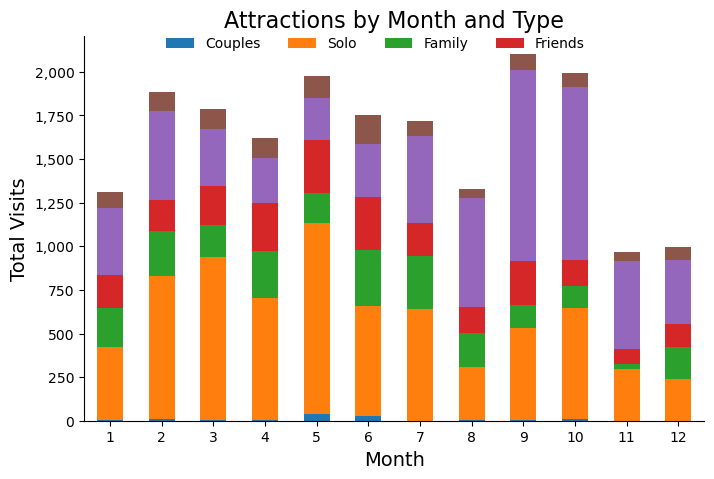

In [33]:
# Aggregate and sort
tempDF = ds.pivot_table(
    values='reviewRating',  
    index='Month',
    columns='tripType',  
    aggfunc='sum',
    fill_value=0
)

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
tempDF.plot(kind='bar', stacked=True, ax=ax)

# Decoration
fmt = "{x:,.0f}"
tick = ticker.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
sns.despine()
plt.title("Attractions by Month and Type", fontsize=16)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Total Visits", fontsize=14)
#ax.set_xticklabels(weekdaysList)
plt.xticks(rotation=0, ha='center')
handles, labels = ax.get_legend_handles_labels()
labels = ['Couples', 'Solo', 'Family', 'Friends']  # Update labels based on your column
ax.legend(handles=handles, labels=labels, loc='upper center', ncol=4, bbox_to_anchor=(0.47, 1.03), frameon=False)

# Show plot
plt.show()

This bar chart uses a different approach to show the total visits for each month, while also splitting them up by trip type, like Couples, Family, or Friends. The data was organized using a pivot table, where we added up the `reviewRating` for each month and grouped it by `tripType`. The stacked bars make it easy to see which months had the most visits and what kind of trips people were taking during those times. It’s a simple but clear way to understand not only the busy months for attractions but also the type of visitors during those times.

This analysis is based on data collected over multiple years, giving us an overall view of visitation trends. Here are some key insights from the chart:

- May, June, and July are the busiest months, which can be explain from the weather and summer holidays.  
- January and December are the least visited months, reflecting the off-season for tourism.  
- Couples are the largest group of visitors throughout the year. 
- Families visit the most during summer, coinciding with school vacations.  
- Friends' trips peak during warmer months, showing a preference for group outings in the summer.  
- Solo trips are steady but smaller, with a slight increase during peak tourism months like July.  
- Business trips are very minimal, indicating these attractions are not commonly visited for work-related purposes.  

In [29]:
# Group data by user and visit date to consolidate visits on the same day
transactions = ds.groupby(['userName', 'reviewVisited'])['localID'].apply(list).reset_index()

# Rename for clarity
transactions.columns = ['User', 'VisitDate', 'Attractions']
transactions

,User,VisitDate,Attractions
0,007JNR@007JNR,2019-04-01,[MAG010]
1,0Garza@0Garza,2020-02-01,"[MAG010, MAG014, MAG032]"
2,101eggie@101eggie,2019-10-01,[MAG032]
3,1104@1104,2019-05-01,[MAG014]
4,110Helen2014@110Helen2014,2020-02-01,[MAG014]
...,...,...,...
3540,Екатерина Г@_C5261QZ,2018-09-01,[MAG047]
3541,Олександр П@X5628EZ_,2020-02-01,"[MAG010, MAG014]"
3542,Симеон Б@FrequentFlier415125,2019-06-01,[MAG032]
3543,יוסי מ@K454TO_,2019-11-01,"[MAG021, MAG032, MAG049]"


This step transforms the dataset into a transactional format, which is essential for applying association rule mining. By grouping visits on the same day, we can:

Identify patterns of co-visited attractions.
Analyze relationships between attractions frequently visited together.

## Modeling 

In [32]:
# Transform transactions into a one-hot encoded DataFrame
te = TransactionEncoder()
encoded_data = te.fit(transactions['Attractions']).transform(transactions['Attractions'])
encoded_df = pd.DataFrame(encoded_data, columns=te.columns_)

# Apply Apriori to find frequent itemsets
frequent_itemsets = apriori(encoded_df, min_support=0.01, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="lift",num_itemsets=len(frequent_itemsets), min_threshold=1)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(MAG049),(MAG021),0.061495,0.196897,0.026516,0.431193,2.189940,1.0,0.014408,1.411907,0.578970,0.114355,0.291738,0.282932
1,(MAG021),(MAG049),0.196897,0.061495,0.026516,0.134670,2.189940,1.0,0.014408,1.084564,0.676584,0.114355,0.077970,0.282932
2,(MAG032),(MAG047),0.241467,0.141044,0.054725,0.226636,1.606846,1.0,0.020668,1.110675,0.497886,0.166954,0.099646,0.307318
3,(MAG047),(MAG032),0.141044,0.241467,0.054725,0.388000,1.606846,1.0,0.020668,1.239433,0.439676,0.166954,0.193180,0.307318
4,"(MAG014, MAG032)",(MAG010),0.026798,0.307193,0.012976,0.484211,1.576241,1.0,0.004744,1.343197,0.375646,0.040422,0.255507,0.263226


In this first step of modeling, we prepared the data for association rule mining by transforming the list of attractions into a one-hot encoded format. This means each attraction got its own column, with 1s and 0s showing whether it was visited or not in each transaction. We then used the Apriori algorithm to find frequent itemsets with a minimum support of 1%. However, when we tried to generate association rules, we ran into an error. The `association_rules` function was missing the `num_itemsets` parameter, which is required to run it properly. This stopped us from moving forward, and we realized we needed to fix this issue before we could continue analyzing the relationships between the attractions.

In [216]:
# Apply Apriori to find frequent itemsets
frequent_itemsets = apriori(encoded_df, min_support=0.01, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, num_itemsets=len(frequent_itemsets), metric="lift", min_threshold=1)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(MAG010),(MAG014),0.320247,0.271605,0.097037,0.303007,1.115616,1.0,0.010056,1.045054,0.152459,0.196108,0.043111,0.330140
1,(MAG014),(MAG010),0.271605,0.320247,0.097037,0.357273,1.115616,1.0,0.010056,1.057607,0.142278,0.196108,0.054470,0.330140
2,(MAG021),(MAG049),0.206420,0.075062,0.037778,0.183014,2.438185,1.0,0.022284,1.132135,0.743288,0.155015,0.116713,0.343152
3,(MAG049),(MAG021),0.075062,0.206420,0.037778,0.503289,2.438185,1.0,0.022284,1.597671,0.637728,0.155015,0.374089,0.343152
4,(MAG047),(MAG032),0.144444,0.248148,0.060000,0.415385,1.673938,1.0,0.024156,1.286062,0.470579,0.180401,0.222433,0.328588
5,(MAG032),(MAG047),0.248148,0.144444,0.060000,0.241791,1.673938,1.0,0.024156,1.128390,0.535486,0.180401,0.113782,0.328588
6,"(MAG010, MAG032)",(MAG014),0.039259,0.271605,0.022716,0.578616,2.130360,1.0,0.012053,1.728579,0.552278,0.078835,0.421490,0.331126
7,"(MAG032, MAG014)",(MAG010),0.039753,0.320247,0.022716,0.571429,1.784337,1.0,0.009985,1.586091,0.457765,0.067350,0.369519,0.321181
8,(MAG010),"(MAG032, MAG014)",0.320247,0.039753,0.022716,0.070933,1.784337,1.0,0.009985,1.033560,0.646658,0.067350,0.032471,0.321181
9,(MAG014),"(MAG010, MAG032)",0.271605,0.039259,0.022716,0.083636,2.130360,1.0,0.012053,1.048427,0.728445,0.078835,0.046191,0.331126


From this table we can take a few conclusions:
- Antecedents and Consequents: These represent the attractions or combinations of attractions found in a transaction. Antecedents are the "if" part, and Consequents are the "then" part of the rule. For example, if a visitor goes to the antecedents (e.g., MAG010 - Torre de Belém), they are likely to visit the consequents (e.g., MAG014 - Mosteiro dos Jerónimos). 
  
- Support: Indicates how frequently the rule appears in the dataset. For instance, a support of 0.097037 means that 9.7% of all transactions include the combination of MAG010 and MAG014.

- Confidence: Measures the reliability of the rule, meaning how likely it is of a rule to correct for a new observation. It tells us the probability that visitors who go to the antecedent attractions also visit the consequent attractions. For example, a confidence of 0.357273 means that 35.7% of the time, visitors of MAG010 also visit MAG014.

- Lift: Shows how much more likely the antecedent and consequent occur together compared to random chance. On a more technical term is the "ratio by which the confidence of a rule exceeds the expected confidence". The lift can be interpreted like this:
  - =1: A and B are independent
  - higher then 1: A and B have complementary effects
  - lower then 1: A and B have a substitution effect between them
    
A lift greater than 1 indicates a strong association. For instance, a lift of 1.115616 for MAG010 and MAG014 suggests a modest positive relationship.

So from this table overall we see that:
- Attractions like Torre de Belém (MAG010) and Mosteiro dos Jerónimos (MAG014) have high support values (e.g., 0.097037), indicating that these two attractions are commonly visited together by tourists.
- The confidence levels for many rules, such as 0.357273 for Torre de Belém → Mosteiro dos Jerónimos, suggest a moderately strong relationship. This means over 35% of visitors to Torre de Belém also visit MostHigher lift values, such as 2.438185 for Ponte de Dom Luís I → Cais da Ribeira, suggest a stronger association. This is likely because these attractions are closely located and part of a natural walking route for visitors.eiro dos Jerónimos, which supports the idea that these attractions are part of a common travel itinerary.
- In Sintra, Park and National Palace of Pena (MAG032) and Quinta da Regaleira (MAG047) are often visited together.
- Some rules involve combinations of three attractions, such as {Quinta da Regaleira, Park and National Palace of Pena} → {Mosteiro dos Jerónimos}. While less common (lower support values like 0.014074), these patterns suggest visitors might combine trips across nearby regions.

In [106]:
# Count visits to each attraction by user
repeat_visits = ds.groupby(['userName', 'localID']).size().reset_index(name='VisitCount')

# Filter for repeated visits
repeat_visits = repeat_visits[repeat_visits['VisitCount'] > 1]
repeat_visits

,userName,localID,VisitCount
83,A1r1ka@A1r1ka,MAG093,2
166,AlbertSalichs@AlbertSalichs,MAG093,3
182,Alexandre C@Alexclondon95,MAG047,2
272,Anfrist@Anfrist,MAG093,2
333,Antoine Pan@lefttalent,MAG093,2
787,Crofton M@croftonMelbourne,MAG093,2
976,Dimitris L@750dimitrisl,MAG093,2
1190,Finds_posts@Lowell-Fin,MAG093,2
1444,Hassan H@720hassan,MAG093,2
1505,Hugo Jepsen@hugojepsen,MAG093,2


In this step, we focused on identifying repeat visits to attractions by grouping the data by users (userName) and attractions (localID) to count how many times each user visited a specific place. We filtered the results to only include users who visited the same attraction more than once, highlighting repeat visits. For example, the table shows that user AlbertSalichs visited MAG093 (Bom Jesus do Monte) three times, while user Thomas V visited MAG014 (Mosteiro dos Jerónimos) twice. From this analysis, we observed that attractions like Bom Jesus do Monte and Mosteiro dos Jerónimos have higher repeat visits, indicating their strong appeal.

In [213]:
# Transform the transactions into a pivot table
# Binary presence of attractions in user visits
pt = pd.pivot_table(ds[['userName', 'localID']],
                    index='userName',                          
                    columns='localID',                          
                    aggfunc=lambda x: 1 if len(x) > 0 else 0,   
                    fill_value=0)

# Apply the Apriori algorithm
# Rules supported in at least 5% of transactions (adjustable based on dataset size)
frequent_itemsets = apriori(pt.astype('bool'), min_support=0.05, use_colnames=True)

# Generate the association rules - by support
rules_support = association_rules(frequent_itemsets, num_itemsets=len(frequent_itemsets), metric="support", min_threshold=0.1)
rules_support.sort_values(by='support', ascending=False, inplace=True)

# Display top 10 rules
print("Top 10 Rules by Support:")
print(rules_support.head(10))


Top 10 Rules by Support:
  antecedents consequents  antecedent support  consequent support  support  \
0    (MAG010)    (MAG014)            0.327774            0.277483  0.10235   
1    (MAG014)    (MAG010)            0.277483            0.327774  0.10235   

   confidence      lift  representativity  leverage  conviction  \
0    0.312259  1.125327               1.0  0.011399    1.050566   
1    0.368852  1.125327               1.0  0.011399    1.065086   

   zhangs_metric   jaccard  certainty  kulczynski  
0       0.165673  0.203518   0.048132    0.340556  
1       0.154141  0.203518   0.061109    0.340556  


In this step, we applied the Apriori algorithm to identify frequent itemsets and generate association rules, focusing on the support metric. The results highlight a strong association between `MAG010` (Torre de Belém) and `MAG014` (Mosteiro dos Jerónimos), with these two attractions appearing together in 10.2% of transactions. This aligns with the insights we previously obtained, reinforcing the idea that these attractions are often visited together, likely due to their close proximity.

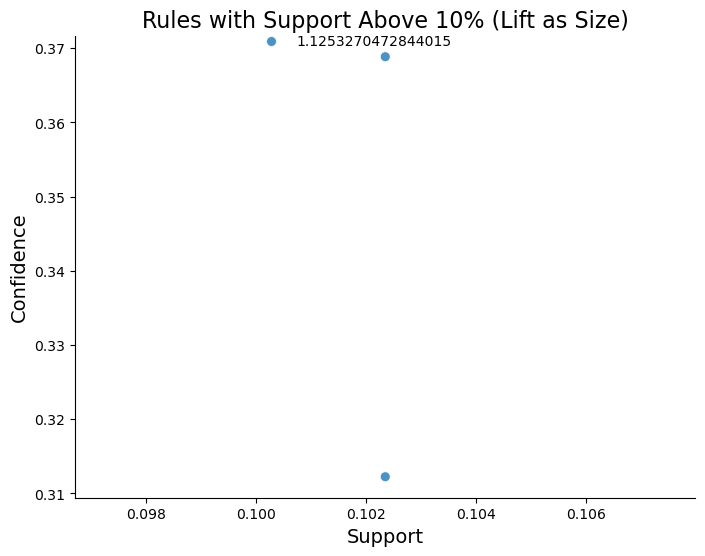

       support  confidence      lift
count  2.00000    2.000000  2.000000
mean   0.10235    0.340556  1.125327
std    0.00000    0.040018  0.000000
min    0.10235    0.312259  1.125327
25%    0.10235    0.326407  1.125327
50%    0.10235    0.340556  1.125327
75%    0.10235    0.354704  1.125327
max    0.10235    0.368852  1.125327


In [229]:
# Scatter plot of the association rules
fig, ax = plt.subplots(figsize=(8, 6))
g = sns.scatterplot(
    data=rules_support,  
    x="support",
    y="confidence",
    size="lift",
    sizes=(50, 500),
    alpha=0.8
)

# Decoration
sns.despine()
plt.title("Rules with Support Above 10% (Lift as Size)", fontsize=16)  

# Replace 'plots_Title_fontSize' with 16
plt.xlabel("Support", fontsize=14)  

# Replace 'subPlots_label_fontSize' with 14
plt.ylabel("Confidence", fontsize=14)
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles=handles,
    labels=labels,
    loc='upper center',
    ncol=6,
    bbox_to_anchor=(0.45, 1.03),
    frameon=False
)

plt.show()

print(rules_support[['support', 'confidence', 'lift']].describe())

We decided to visualize the association rules using a scatter plot, where the x-axis represents support, the y-axis represents confidence, and the size of the points corresponds to lift. To focus on the most significant patterns, we filtered the rules to only include those with support above 10%. However, when we generated the scatter plot, it displayed only a couple of points, which led us to investigate further.

After reviewing the summary statistics for support, confidence, and lift, we noticed that the values were very close together, especially lift, which remained consistent at 1.125 for the displayed rules. This lack of variation made the scatter plot less informative since the points were not well distributed, limiting its ability to highlight meaningful patterns. This step showed us the importance of checking the data distribution and adjusting thresholds to better capture and visualize trends in the data.

In [232]:
print(encoded_df.describe())
print(encoded_df.nunique())

       MAG010 MAG014 MAG021 MAG032 MAG047 MAG049 MAG093
count    4050   4050   4050   4050   4050   4050   4050
unique      2      2      2      2      2      2      2
top     False  False  False  False  False  False  False
freq     2753   2950   3214   3045   3465   3746   3914
MAG010    2
MAG014    2
MAG021    2
MAG032    2
MAG047    2
MAG049    2
MAG093    2
dtype: int64


In [207]:
# Generate the association rules - by confidence
rulesConfidence = association_rules(frequent_itemsets, num_itemsets=len(frequent_itemsets), metric="confidence", min_threshold=0.40)
rulesConfidence.sort_values(by='confidence', ascending=False, inplace=True)
print(rulesConfidence.head(10))

        antecedents consequents  antecedent support  consequent support  \
7  (MAG047, MAG014)    (MAG032)            0.018519            0.248148   
6  (MAG010, MAG047)    (MAG032)            0.020247            0.248148   
5  (MAG047, MAG014)    (MAG010)            0.018519            0.320247   
2  (MAG010, MAG032)    (MAG014)            0.039259            0.271605   
3  (MAG032, MAG014)    (MAG010)            0.039753            0.320247   
4  (MAG010, MAG047)    (MAG014)            0.020247            0.271605   
0          (MAG049)    (MAG021)            0.075062            0.206420   
1          (MAG047)    (MAG032)            0.144444            0.248148   

    support  confidence      lift  representativity  leverage  conviction  \
7  0.014074    0.760000  3.062687               1.0  0.009479    3.132716   
6  0.013333    0.658537  2.653804               1.0  0.008309    2.201852   
5  0.011358    0.613333  1.915189               1.0  0.005428    1.757982   
2  0.022716    0

### Explore frequent itemsets¶

In [119]:
# Add a column with the length
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

In [165]:
# Length=2 and Support>=0.1
frequent_itemsets[(frequent_itemsets['length'] == 2) & (frequent_itemsets['support'] >= 0.1)]

,support,itemsets,length
6,0.10235,"(MAG010, MAG014)",2


To deepen our analysis, we attempted to filter for association rules that had the highest confidence (≥ 0.9) and lift (≥ 2). The goal was to identify the strongest and most reliable patterns that could inform recommendations for visitors. 

In [153]:
# High Confidence and high Lift
rulesConfidence[(rulesConfidence['confidence'] >= 0.9) & (rulesConfidence['lift'] >= 2)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski,antecedents_,consequents_


We attempted to find the highest confidence and high lift we could. As we gathered no results we decided to find the substitute attractions, ir order to see what suggestions we could make for someone that would want to visit something else 

In [262]:
# Substitue attractions
rulesLift2 = association_rules(frequent_itemsets, num_itemsets=len(frequent_itemsets), metric="lift", min_threshold=0.0)
rulesLift2.sort_values(by='lift', ascending=True, inplace=True)
rulesLift2. head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
2,(MAG021),(MAG010),0.206420,0.320247,0.014321,0.069378,0.216639,1.0,-0.051784,0.730429,-0.820032,0.027952,-0.369059,0.057048
3,(MAG010),(MAG021),0.320247,0.206420,0.014321,0.044719,0.216639,1.0,-0.051784,0.830729,-0.841761,0.027952,-0.203762,0.057048
15,(MAG032),(MAG021),0.248148,0.206420,0.011111,0.044776,0.216918,1.0,-0.040112,0.830779,-0.827632,0.025056,-0.203689,0.049302
14,(MAG021),(MAG032),0.206420,0.248148,0.011111,0.053828,0.216918,1.0,-0.040112,0.794625,-0.819789,0.025056,-0.258456,0.049302
8,(MAG021),(MAG014),0.206420,0.271605,0.012346,0.059809,0.220204,1.0,-0.043719,0.774731,-0.816929,0.026511,-0.290771,0.052632
9,(MAG014),(MAG021),0.271605,0.206420,0.012346,0.045455,0.220204,1.0,-0.043719,0.831370,-0.829401,0.026511,-0.202834,0.052632
6,(MAG010),(MAG047),0.320247,0.144444,0.020247,0.063223,0.437696,1.0,-0.026011,0.913297,-0.653971,0.045556,-0.094934,0.101697
7,(MAG047),(MAG010),0.144444,0.320247,0.020247,0.140171,0.437696,1.0,-0.026011,0.790568,-0.600253,0.045556,-0.264914,0.101697
13,(MAG014),(MAG047),0.271605,0.144444,0.018519,0.068182,0.472028,1.0,-0.020713,0.918157,-0.605615,0.046584,-0.089138,0.098193
12,(MAG047),(MAG014),0.144444,0.271605,0.018519,0.128205,0.472028,1.0,-0.020713,0.835512,-0.566604,0.046584,-0.196871,0.098193


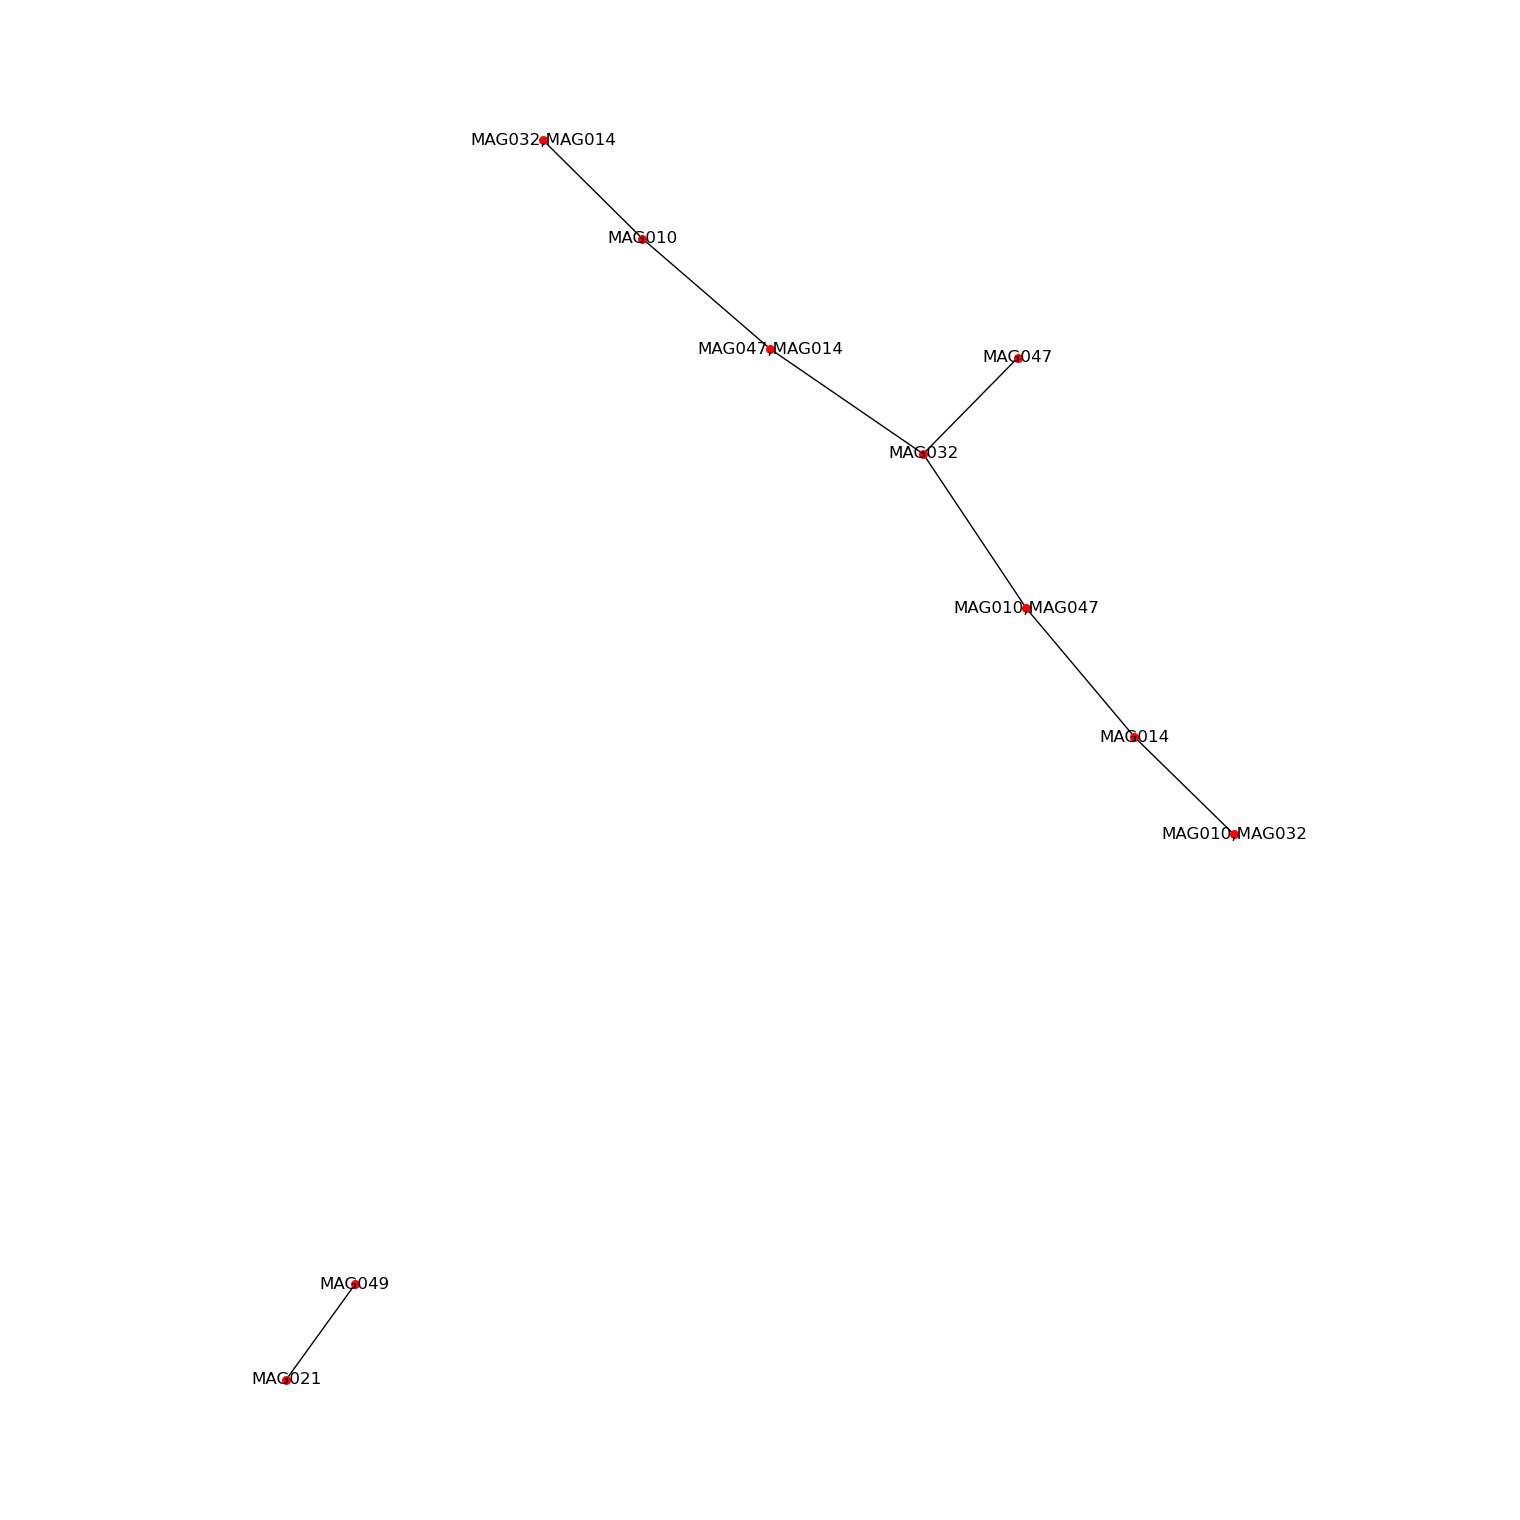

In [266]:
# Plot a basic network graph of the top 20 confidence rules

# Create a copy of the rules and transform the frozensets to strings
rulesToPlot = rulesConfidence.copy(deep=True)
rulesToPlot['LHS'] = [','.join(list(x)) for x in rulesToPlot['antecedents']]
rulesToPlot['RHS'] = [','.join(list(x)) for x in rulesToPlot['consequents']]

# Remove duplicate if reversed rules
rulesToPlot['sortedRow'] = [sorted([a,b]) for a,b in zip(rulesToPlot.LHS, rulesToPlot.RHS)]
rulesToPlot['sortedRow'] = rulesToPlot['sortedRow'].astype(str)
rulesToPlot.drop_duplicates(subset=['sortedRow'], inplace=True)

# Plot
rulesToPlot=rulesToPlot[:20]
fig = plt.figure(figsize=(15, 15)) 
G = nx.from_pandas_edgelist(rulesToPlot, 'LHS', 'RHS')
np.random.seed(1234)
nx.draw(G, with_labels=True, node_size=30, node_color="red", pos=nx.spring_layout(G))
plt.axis('equal')
plt.show()

In this final step, we created a network graph to visualize the relationships between attractions based on the top 20 association rules with the highest confidence. Each node represents an attraction, and the lines (edges) connecting them show how strongly they are associated. This helps us see which attractions are commonly visited together.

Looking at the graph, we noticed some clusters, like MAG010 (Belém Tower) and MAG032 (Pena Palace), which seem to have stronger connections with other attractions. This supports our earlier findings about certain attractions being complementary. On the other hand, attractions like MAG021 (Ponte de Dom Luís I) and MAG049 (Cais da Ribeira) appear more isolated, showing they don’t have as many associations in the dataset.

This visualization is a simple way to summarize the connections we found and understand how visitors might group their visits around certain attractions. It gives a clear picture of how the attractions are linked in terms of visitor behavior.